Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)
Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04558682,  0.02160218, -0.02904392,  0.03054327], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04515478,  0.21712834, -0.02843306, -0.27115998], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})
step = 200: loss = 15.114992141723633
step = 400: loss = 10.50606918334961
step = 600: loss = 15.23393440246582
step = 800: loss = 15.9775419

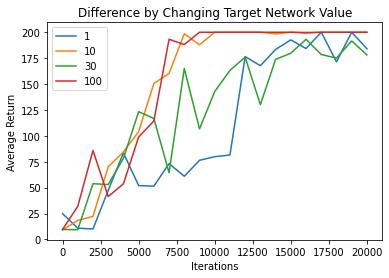

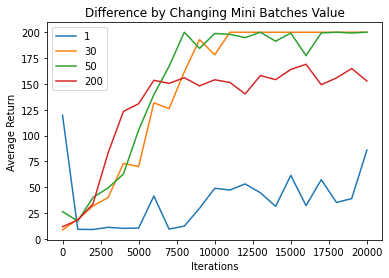

In [ ]:
# -*- coding: utf-8 -*-
"""cs885_dqn_tutorial.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1oGf8eHvCOL_sbuk8xxitE_HAvnxt9Zl6

##### Copyright 2018 The TF-Agents Authors.

This tutorial was modified slightly for the purpose of CS885 by Pascal Poupart
"""

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""# Train a Deep Q Network with TF-Agents

## Introduction

This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  agent on the Cartpole environment using the TF-Agents library.

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

It will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


To run this code live, click the 'Run in Google Colab' link above.

### Setup

*If* you haven't installed the following dependencies, run:
"""

from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

tf.version.VERSION

def train(num_iterations = 20000, initial_collect_steps = 1000, \
  collect_steps_per_iteration = 1, \
  replay_buffer_max_length = 100000, batch_size = 30, \
  learning_rate = 1e-3, log_interval = 200, num_eval_episodes = 10, \
  eval_interval = 1000, target_update_period = 10) :

  """## Environment

  In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

  Load the CartPole environment from the OpenAI Gym suite. 
  """

  env_name = 'CartPole-v0'
  env = suite_gym.load(env_name)

  """You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up."""

  env.reset()
  PIL.Image.fromarray(env.render())

  """The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

  The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.

  """

  print('Observation Spec:')
  print(env.time_step_spec().observation)

  print('Reward Spec:')
  print(env.time_step_spec().reward)

  """The `action_spec()` method returns the shape, data types, and allowed values of valid actions."""

  print('Action Spec:')
  print(env.action_spec())

  """In the Cartpole environment:

  -   `observation` is an array of 4 floats: 
      -   the position and velocity of the cart
      -   the angular position and velocity of the pole 
  -   `reward` is a scalar float value
  -   `action` is a scalar integer with only two possible values:
      -   `0` — "move left"
      -   `1` — "move right"

  """

  time_step = env.reset()
  print('Time step:')
  print(time_step)

  action = np.array(1, dtype=np.int32)

  next_time_step = env.step(action)
  print('Next time step:')
  print(next_time_step)

  """Usually two environments are instantiated: one for training and one for evaluation. """

  train_py_env = suite_gym.load(env_name)
  eval_py_env = suite_gym.load(env_name)

  """The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

  The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.

  """

  train_env = tf_py_environment.TFPyEnvironment(train_py_env)
  eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

  """## Agent

  The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

  -   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
  -   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
  -   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
  -   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
  -   [PPO](https://arxiv.org/abs/1707.06347)
  -   [SAC](https://arxiv.org/abs/1801.01290).

  The DQN agent can be used in any environment which has a discrete action space.

  At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

  Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.

  """

  fc_layer_params = (100,)

  q_net = q_network.QNetwork(
      train_env.observation_spec(),
      train_env.action_spec(),
      fc_layer_params=fc_layer_params)

  """Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter."""

  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

  train_step_counter = tf.Variable(0)

  agent = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss,
      train_step_counter=train_step_counter,
      target_update_period=target_update_period)

  agent.initialize()

  """## Policies

  A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

  In this tutorial:

  -   The desired outcome is keeping the pole balanced upright over the cart.
  -   The policy returns an action (left or right) for each `time_step` observation.

  Agents contain two policies: 

  -   `agent.policy` — The main policy that is used for evaluation and deployment.
  -   `agent.collect_policy` — A second policy that is used for data collection.

  """

  eval_policy = agent.policy
  collect_policy = agent.collect_policy

  """Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`."""

  random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                  train_env.action_spec())

  """To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

  -   `action` — the action to be taken (in this case, `0` or `1`)
  -   `state` — used for stateful (that is, RNN-based) policies
  -   `info` — auxiliary data, such as log probabilities of actions
  """

  example_environment = tf_py_environment.TFPyEnvironment(
      suite_gym.load('CartPole-v0'))

  time_step = example_environment.reset()

  random_policy.action(time_step)

  """## Metrics and Evaluation

  The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

  The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

  """


  def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]



  """Running this computation on the `random_policy` shows a baseline performance in the environment."""

  compute_avg_return(eval_env, random_policy, num_eval_episodes)

  """## Replay Buffer

  The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

  The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.

  """

  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.collect_data_spec,
      batch_size=train_env.batch_size,
      max_length=replay_buffer_max_length)

  """For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items."""

  agent.collect_data_spec

  agent.collect_data_spec._fields

  """## Data Collection

  Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.
  """

  def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    buffer.add_batch(traj)

  def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
      collect_step(env, policy, buffer)

  collect_data(train_env, random_policy, replay_buffer, steps=100)


  """The replay buffer is now a collection of Trajectories."""



  """The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

  Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

  This dataset is also optimized by running parallel calls and prefetching data.
  """

  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)


  dataset

  iterator = iter(dataset)

  print(iterator)


  """## Training the agent

  Two things must happen during the training loop:

  -   collect data from the environment
  -   use that data to train the agent's neural network(s)

  This example also periodicially evaluates the policy and prints the current score.

  The following will take ~5 minutes to run.
  """


  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  agent.train = common.function(agent.train)

  # Reset the train step
  agent.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  returns = [avg_return]

  for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
      collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)

  """## Visualization

  ### Plots

  Use `matplotlib.pyplot` to chart how the policy improved during training.

  One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)
  """

  iterations = range(0, num_iterations + 1, eval_interval)
  '''plt.plot(iterations, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Iterations')
  plt.ylim(top=250)'''

  return [iterations, returns]
#END train

#generates the solution to section one of part three
solutions = []
for targetNetwork in [1, 10, 30, 100] :
  solutions.append(train(target_update_period=targetNetwork))
#END FOR

#generates the solution to section two of part three
solutionsTwo = []
for miniBatches in [1, 30, 50, 200] :
  solutionsTwo.append(train(batch_size=miniBatches))
#END FOR

#plot section one
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.title("Difference by Changing Target Network Value")

for result in range(len(solutions)):
  plt.plot(solutions[result][0], solutions[result][1], label = [1, 10, 30, 100][result])
#END FOR

#show legend
plt.legend()

#show the plot
plt.show()

#clear the plot
plt.cla()

#plot section two
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.title("Difference by Changing Mini Batches Value")

for result in range(len(solutionsTwo)):
  plt.plot(solutionsTwo[result][0], solutionsTwo[result][1], label = [1, 30, 50, 200][result])
#END FOR

#show legend
plt.legend()

#show the plot
plt.show()